# Model 1

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, average_precision_score, roc_auc_score, roc_curve

In [2]:
model_df = pd.read_csv("status.csv")
model_df.head()

,hypertension,heart_disease,diabetes,problematic,gender,smoking_history_No Info,smoking_history_current,smoking_history_not current,age,bmi,HbA1c_level,blood_glucose_level
0,0,1,0,0,0,0.0,0.0,1.0,1.000000,-0.645658,0.127273,-0.454545
1,0,0,0,0,0,1.0,0.0,0.0,0.349349,-0.595938,0.127273,-1.000000
2,0,0,0,0,1,0.0,0.0,1.0,-0.301301,-0.595938,-0.200000,-0.290909
3,0,0,0,0,0,0.0,1.0,0.0,-0.101101,-0.686275,-0.454545,-0.318182
4,1,1,0,0,1,0.0,1.0,0.0,0.899900,-0.763539,-0.527273,-0.318182


In [3]:
# Define features (X) and target (y)
X = model_df.drop(["diabetes"],axis=1)
y = model_df[["diabetes"]]

In [4]:
# Split data into training and test sets
X_train_, X_test, y_train_, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

In [5]:
# Random Under-Sampling to balance the training set
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train_, y_train_)
X_train.shape, X_test.shape

/Users/durudemirbag/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/durudemirbag/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


((15300, 11), (9999, 11))

In [6]:
# Define the hyperparameter grid
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 1],
    'reg_lambda': [1, 2]
}

# Initialize XGBoost classifier
model = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# Hyperparameter search with cross-validation
grid = GridSearchCV(
    estimator=model,
    param_grid=params,
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.05, 0.1, 0.2, 0.3],
                         'max_depth': [5, 10, 15, 20],
                         'n_estimators': [100, 200, 300], 'reg_alpha': [0, 1],
                         'reg_lambda': [1, 2], 'subsample': [0.8, 1.0]},
             verbose=1)

In [7]:
print("Best Params:", grid.best_params_)
best_model = grid.best_estimator_

Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 1, 'reg_lambda': 2, 'subsample': 0.8}


In [8]:
# Evaluate model performance on training data
y_prob_train = best_model.predict_proba(X_train)[:, 1]
y_pred_train = (y_prob_train >= 0.5).astype(int)

print(classification_report(y_train, y_pred_train))
print(confusion_matrix(y_train, y_pred_train))
print("AUC Score:", roc_auc_score(y_train, y_prob_train))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7650
           1       0.92      0.94      0.93      7650

    accuracy                           0.93     15300
   macro avg       0.93      0.93      0.93     15300
weighted avg       0.93      0.93      0.93     15300

[[7004  646]
 [ 472 7178]]
AUC Score: 0.9851868170361826


In [9]:
# Evaluate model performance on test data
y_prob_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= 0.5).astype(int)

print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
print("AUC Score:", roc_auc_score(y_test, y_prob_test))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      9149
           1       0.48      0.92      0.63       850

    accuracy                           0.91      9999
   macro avg       0.74      0.91      0.79      9999
weighted avg       0.95      0.91      0.92      9999

[[8301  848]
 [  66  784]]
AUC Score: 0.9807621533693814


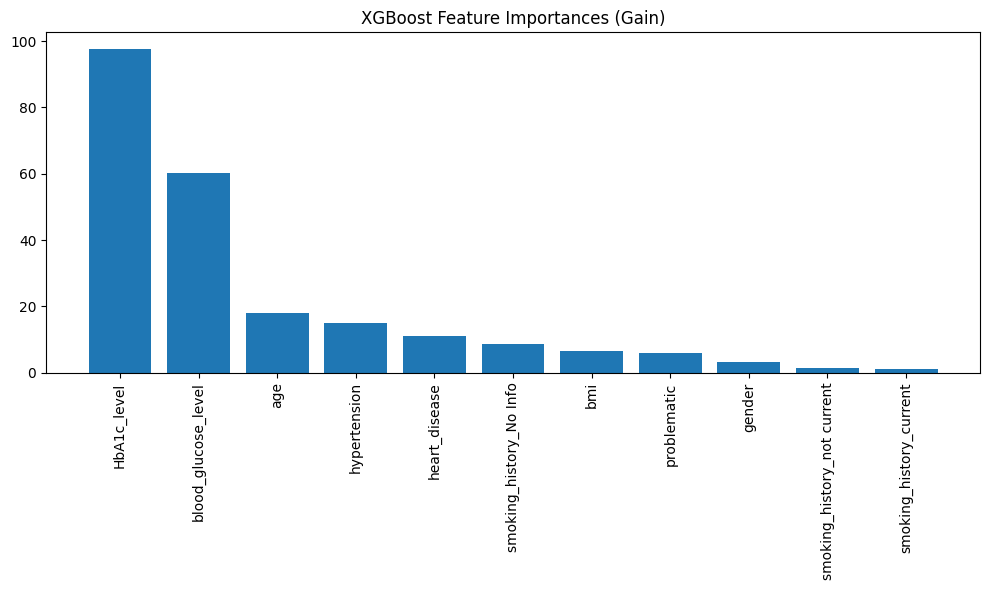

In [10]:
# Feature importance plot
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

booster = best_model.get_booster()
importances = booster.get_score(importance_type='gain')

values = np.array([importances.get(f, 0) for f in feature_names])

indices = np.argsort(values)[::-1]

plt.figure(figsize=(10, 6))
plt.title("XGBoost Feature Importances (Gain)")
plt.bar(range(len(values)), values[indices])
plt.xticks(range(len(values)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

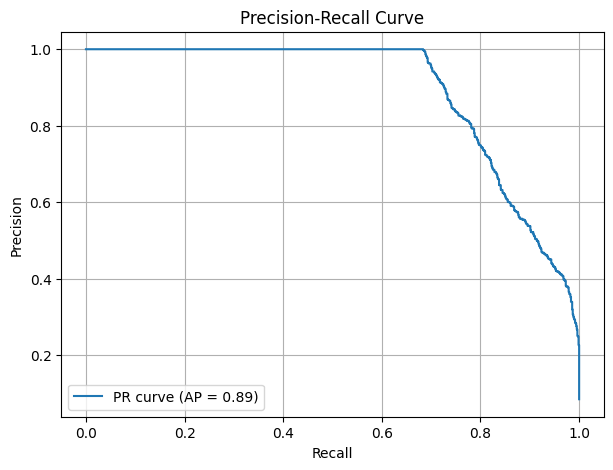

In [11]:
#Precision Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test)

ap = average_precision_score(y_test, y_prob_test)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f'PR curve (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [12]:
valid_idx = np.where(recall > 0.85)

precision_valid = precision[valid_idx]
recall_valid = recall[valid_idx]
thresholds_valid = thresholds[valid_idx[0]-1]  

best_idx = np.argmax(precision_valid)
best_precision = precision_valid[best_idx]
best_recall = recall_valid[best_idx]
best_threshold = thresholds_valid[best_idx]

print("Best Threshold:", best_threshold)

y_pred_opt = (y_prob_test >= best_threshold).astype(int)


print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_opt))

cm_opt = confusion_matrix(y_test, y_pred_opt)
print("Confusion Matrix (Optimized Threshold):\n", cm_opt)

Best Threshold: 0.66116256

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      9149
           1       0.62      0.85      0.72       850

    accuracy                           0.94      9999
   macro avg       0.80      0.90      0.84      9999
weighted avg       0.95      0.94      0.95      9999

Confusion Matrix (Optimized Threshold):
 [[8701  448]
 [ 127  723]]


In [13]:
valid_idx = np.where(recall > 0.90)

precision_valid = precision[valid_idx]
recall_valid = recall[valid_idx]
thresholds_valid = thresholds[valid_idx[0]-1]  

best_idx = np.argmax(precision_valid)
best_precision = precision_valid[best_idx]
best_recall = recall_valid[best_idx]
best_threshold = thresholds_valid[best_idx]

print("Best Threshold:", best_threshold)

y_pred_opt = (y_prob_test >= best_threshold).astype(int)


print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_opt))

cm_opt = confusion_matrix(y_test, y_pred_opt)
print("Confusion Matrix (Optimized Threshold):\n", cm_opt)

Best Threshold: 0.5726467

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      9149
           1       0.54      0.90      0.67       850

    accuracy                           0.93      9999
   macro avg       0.76      0.91      0.82      9999
weighted avg       0.95      0.93      0.93      9999

Confusion Matrix (Optimized Threshold):
 [[8489  660]
 [  84  766]]
